In [1]:
ultrasound_size = 128

data_folder = r"SpineScan2"

ultrasound_file = r"ultrasound.npy"
segmentation_file = r"segmentation.npy"

test_ultrasound_file = r"ultrasound-test.npy"
test_segmentation_file = r"segmentation-test.npy"

In [2]:
import datetime
import numpy as np
import os 

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
import keras_metrics

from local_vars import root_folder

Using TensorFlow backend.


In [3]:
data_fullpath = os.path.join(root_folder, data_folder)

ultrasound_fullname = os.path.join(data_fullpath, ultrasound_file)
segmentation_fullname = os.path.join(data_fullpath, segmentation_file)

print("Reading ultrasound images from:  {}".format(ultrasound_fullname))
print("Reading segmentations from:      {}".format(segmentation_fullname))

ultrasound_data = np.load(ultrasound_fullname)
segmentation_data = np.load(segmentation_fullname)

num_ultrasound = ultrasound_data.shape[0]
num_segmentation = segmentation_data.shape[0]

print("\nFound {} ultrasound images and {} segmentations".format(num_ultrasound, num_segmentation))

Reading ultrasound images from:  C:\Users\victoria\05-21-2019 SpineExport\SpineScan2\ultrasound.npy
Reading segmentations from:      C:\Users\victoria\05-21-2019 SpineExport\SpineScan2\segmentation.npy

Found 2880 ultrasound images and 2880 segmentations


In [4]:
test_ultrasound_fullname = os.path.join(data_fullpath, test_ultrasound_file)
test_segmentation_fullname = os.path.join(data_fullpath, test_segmentation_file)

print("Reading test ultrasound from: {}".format(test_ultrasound_fullname))
print("Reading test segmentation from : {}".format(test_segmentation_fullname))

test_ultrasound_data = np.load(test_ultrasound_fullname)
test_segmentation_data = np.load(test_segmentation_fullname)

num_test_ultrasound = test_ultrasound_data.shape[0]
num_test_segmentation = test_segmentation_data.shape[0]

print("\nFound {} test ultrasound images and {} segmentations".format(num_test_ultrasound, num_test_segmentation))

Reading test ultrasound from: C:\Users\victoria\05-21-2019 SpineExport\SpineScan2\ultrasound-test.npy
Reading test segmentation from : C:\Users\victoria\05-21-2019 SpineExport\SpineScan2\segmentation-test.npy

Found 721 test ultrasound images and 721 segmentations


In [5]:
import keras.utils
import scipy.ndimage

max_rotation_angle = 10

class UltrasoundSegmentationBatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions=(ultrasound_size, ultrasound_size),
                 shuffle=True,
                 n_channels=1,
                 n_classes=2):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    
    def __len__(self):
        return int(np.floor(self.number_of_images / self.batch_size))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        y = np.empty((self.batch_size, *self.image_dimensions))
        
        for i in range(self.batch_size):
            flip_flag = np.random.randint(2)
            if flip_flag == 1:
                x[i,:,:,:] = np.flip(self.x[batch_indexes[i],:,:,:], axis=1)
                y[i,:,:] = np.flip(self.y[batch_indexes[i],:,:], axis=1)
            else:
                x[i,:,:,:] = self.x[batch_indexes[i],:,:,:]
                y[i,:,:] = self.y[batch_indexes[i],:,:]
        
        angle = np.random.randint(-max_rotation_angle, max_rotation_angle) 
        x_rot = scipy.ndimage.interpolation.rotate(x, angle, (1,2), False, mode="constant", cval=0, order=0)
        y_rot = scipy.ndimage.interpolation.rotate(y, angle, (1,2), False, mode="constant", cval=0, order=0)
        
        x_rot = np.clip(x_rot, 0.0, 1.0)
        y_rot = np.clip(y_rot, 0.0, 1.0)
        
        y_onehot = keras.utils.to_categorical(y_rot, self.n_classes)
        return x_rot, y_onehot

In [6]:
# Prepare dilated output

def dialateStack(segmentation_data, iterations):
    return np.array([scipy.ndimage.binary_dilation(y, iterations=iterations) for y in segmentation_data])

width = 1
segmentation_dilated = dialateStack(segmentation_data[:, :, :, 0], width)

In [7]:
# Testing batch generator

batch_size = 4
num_show = 2

tgen = UltrasoundSegmentationBatchGenerator(ultrasound_data, segmentation_dilated, batch_size, shuffle=False)

bx, by = tgen.__getitem__(0)

import matplotlib.pyplot as plt

i = np.random.randint(batch_size)

fig = plt.figure(figsize=(18,4*num_show))
for i in range(num_show):
    a1 = fig.add_subplot(num_show,3,i*3+1)
    img1 = a1.imshow(bx[i, :, :, 0], vmin=0.0, vmax=1.0)
    a1.set_title("Ultrasound #{}".format(i))
    c = fig.colorbar(img1)
    a2 = fig.add_subplot(num_show,3,i*3+2)
    img2 = a2.imshow(by[i, :, :, 0], vmin=0.0, vmax=1.0)
    a2.set_title("Class 0 #{}".format(i))
    c = fig.colorbar(img2)
    a3 = fig.add_subplot(num_show,3,i*3+3)
    img3 = a3.imshow(by[i, :, :, 1], vmin=0.0, vmax=1.0)
    a3.set_title("Class 1 #{}".format(i))
    c = fig.colorbar(img3)

In [8]:
num_classes = 2
max_learning_rate = 0.01
min_learning_rate = 0.00001
num_epochs = 100

learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

def nvidia_unet(patch_size=ultrasound_size, num_classes=num_classes):
    input_ = Input((patch_size, patch_size, 1))
    skips = []
    output = input_
    c = num_classes
    
    for shape, filters in zip([5, 3, 3, 3, 3, 3, 3], [c*8, c*16, c*32, c*32, c*32, c*32, c*32]):
        skips.append(output)
        output= Conv2D(filters, (shape, shape), strides=2, padding="same", activation="relu")(output)
    
    for shape, filters in zip([4, 4, 4, 4, 4, 4, 4, 4], [c*32, c*32, c*32, c*32, c*16, c*8, c]):
        output = keras.layers.UpSampling2D()(output)
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=3)
        if filters != c:
            activation = "relu"
        else:
            activation = "softmax"
        output = Conv2D(filters, (shape, shape), activation=activation, padding="same")(output)
        if filters != c:
            output = BatchNormalization(momentum=.9)(output)
    
    assert len(skips) == 0
    return Model([input_], [output])

model = nvidia_unet(ultrasound_size, num_classes)

model.compile(optimizer=keras.optimizers.adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss= "binary_crossentropy",
               metrics=["accuracy", keras_metrics.precision(), keras_metrics.recall(), keras_metrics.f1_score()])

print("Learning rate decay = {}".format(learning_rate_decay))

# model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Learning rate decay = 9.99e-05


In [9]:
batch_size = 20

training_generator = UltrasoundSegmentationBatchGenerator(ultrasound_data, segmentation_dilated, batch_size)
test_generator = UltrasoundSegmentationBatchGenerator(test_ultrasound_data, test_segmentation_data[:, :, :, 0], batch_size)

training_time_start = datetime.datetime.now()

training_log = model.fit_generator(training_generator,
                                   validation_data=test_generator,
                                   epochs=num_epochs,
                                   verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
144/144 [==============================] - 12s 83ms/step - loss: 0.1471 - acc: 0.9466 - precision: 0.9760 - recall: 0.9687 - f1_score: 0.9723 - val_loss: 0.0591 - val_acc: 0.9828 - val_precision: 0.9832 - val_recall: 0.9995 - val_f1_score: 0.9913
Epoch 2/100
144/144 [==============================] - 9s 64ms/step - loss: 0.0713 - acc: 0.9751 - precision: 0.9785 - recall: 0.9962 - f1_score: 0.9873 - val_loss: 0.0498 - val_acc: 0.9844 - val_precision: 0.9872 - val_recall: 0.9971 - val_f1_score: 0.9921
Epoch 3/100
144/144 [==============================] - 9s 63ms/step - loss: 0.0676 - acc: 0.9758 - precision: 0.9793 - recall: 0.9960 - f1_score: 0.9876 - val_loss: 0.0504 - val_acc: 0.9844 - val_precision: 0.9896 - val_recall: 0.9945 - val_f1_score: 0.9921
Epoch 4/100
144/144 [==============================] - 9s 63ms/step - loss: 0.0640 - acc: 0.9762 - 

Epoch 62/100
144/144 [==============================] - 9s 63ms/step - loss: 0.0264 - acc: 0.9888 - precision: 0.9935 - recall: 0.9950 - f1_score: 0.9942 - val_loss: 0.0595 - val_acc: 0.9801 - val_precision: 0.9918 - val_recall: 0.9879 - val_f1_score: 0.9899
Epoch 63/100
144/144 [==============================] - 9s 63ms/step - loss: 0.0261 - acc: 0.9889 - precision: 0.9935 - recall: 0.9950 - f1_score: 0.9943 - val_loss: 0.0668 - val_acc: 0.9773 - val_precision: 0.9927 - val_recall: 0.9841 - val_f1_score: 0.9884
Epoch 64/100
144/144 [==============================] - 9s 64ms/step - loss: 0.0260 - acc: 0.9889 - precision: 0.9936 - recall: 0.9950 - f1_score: 0.9943 - val_loss: 0.0633 - val_acc: 0.9794 - val_precision: 0.9922 - val_recall: 0.9867 - val_f1_score: 0.9895
Epoch 65/100
144/144 [==============================] - 9s 64ms/step - loss: 0.0266 - acc: 0.9887 - precision: 0.9934 - recall: 0.9950 - f1_score: 0.9942 - val_loss: 0.0607 - val_acc: 0.9803 - val_precision: 0.9921 - val_re

Epoch 94/100
144/144 [==============================] - 9s 64ms/step - loss: 0.0230 - acc: 0.9902 - precision: 0.9944 - recall: 0.9955 - f1_score: 0.9949 - val_loss: 0.0660 - val_acc: 0.9795 - val_precision: 0.9921 - val_recall: 0.9870 - val_f1_score: 0.9895
Epoch 95/100
144/144 [==============================] - 9s 63ms/step - loss: 0.0228 - acc: 0.9903 - precision: 0.9945 - recall: 0.9955 - f1_score: 0.9950 - val_loss: 0.0662 - val_acc: 0.9801 - val_precision: 0.9919 - val_recall: 0.9877 - val_f1_score: 0.9898
Epoch 96/100
144/144 [==============================] - 9s 63ms/step - loss: 0.0231 - acc: 0.9901 - precision: 0.9944 - recall: 0.9954 - f1_score: 0.9949 - val_loss: 0.0706 - val_acc: 0.9769 - val_precision: 0.9927 - val_recall: 0.9837 - val_f1_score: 0.9882
Epoch 97/100
144/144 [==============================] - 9s 63ms/step - loss: 0.0229 - acc: 0.9902 - precision: 0.9945 - recall: 0.9954 - f1_score: 0.9950 - val_loss: 0.0695 - val_acc: 0.9783 - val_precision: 0.9924 - val_re

In [10]:
training_time_stop = datetime.datetime.now()
print("Training started at: {}".format(training_time_start))
print("Training stopped at: {}".format(training_time_stop))
print("Total training time: {}".format(training_time_stop-training_time_start))

Training started at: 2019-06-19 11:48:35.265491
Training stopped at: 2019-06-19 12:04:02.834554
Total training time: 0:15:27.569063


In [11]:
y_pred = model.predict(test_ultrasound_data)
score = model.evaluate_generator(test_generator, verbose=0)
print("Loss: ", score[0])
print("Accuracy: ", score[1])
print("Precision: ", score[2])
print("Recall: ", score[3])
print("F1 Score: ", score[4])

Loss:  0.06566139248510201
Accuracy:  0.9789038797219595
Precision:  0.9924911660777298
Recall:  0.9859555163832349
F1 Score:  0.9892124962176223


In [12]:
'''
Hausdorff distance metric
Greatest distance from a point in one contour to the closest point in the other contour
'''
from scipy.spatial.distance import directed_hausdorff
import pandas as pd

num_test = test_ultrasound_data.shape[0]

avg_haus = 0
max_haus = 0
distances = np.zeros(num_test)

for i in range(num_test):
    u = y_pred[i, :, :, 1] 
    v = test_segmentation_data[i, :, :, 0]
    dist = directed_hausdorff(u, v)[0]
    distances[i] = dist
    avg_haus += dist
    
    if (dist > max_haus):
        max_haus = dist
    
avg_haus = avg_haus/num_test
df = pd.DataFrame(data=distances)
print(df.describe())

                0
count  721.000000
mean     3.413825
std      1.333319
min      0.003032
25%      2.699424
50%      3.634719
75%      4.397369
max      7.800879


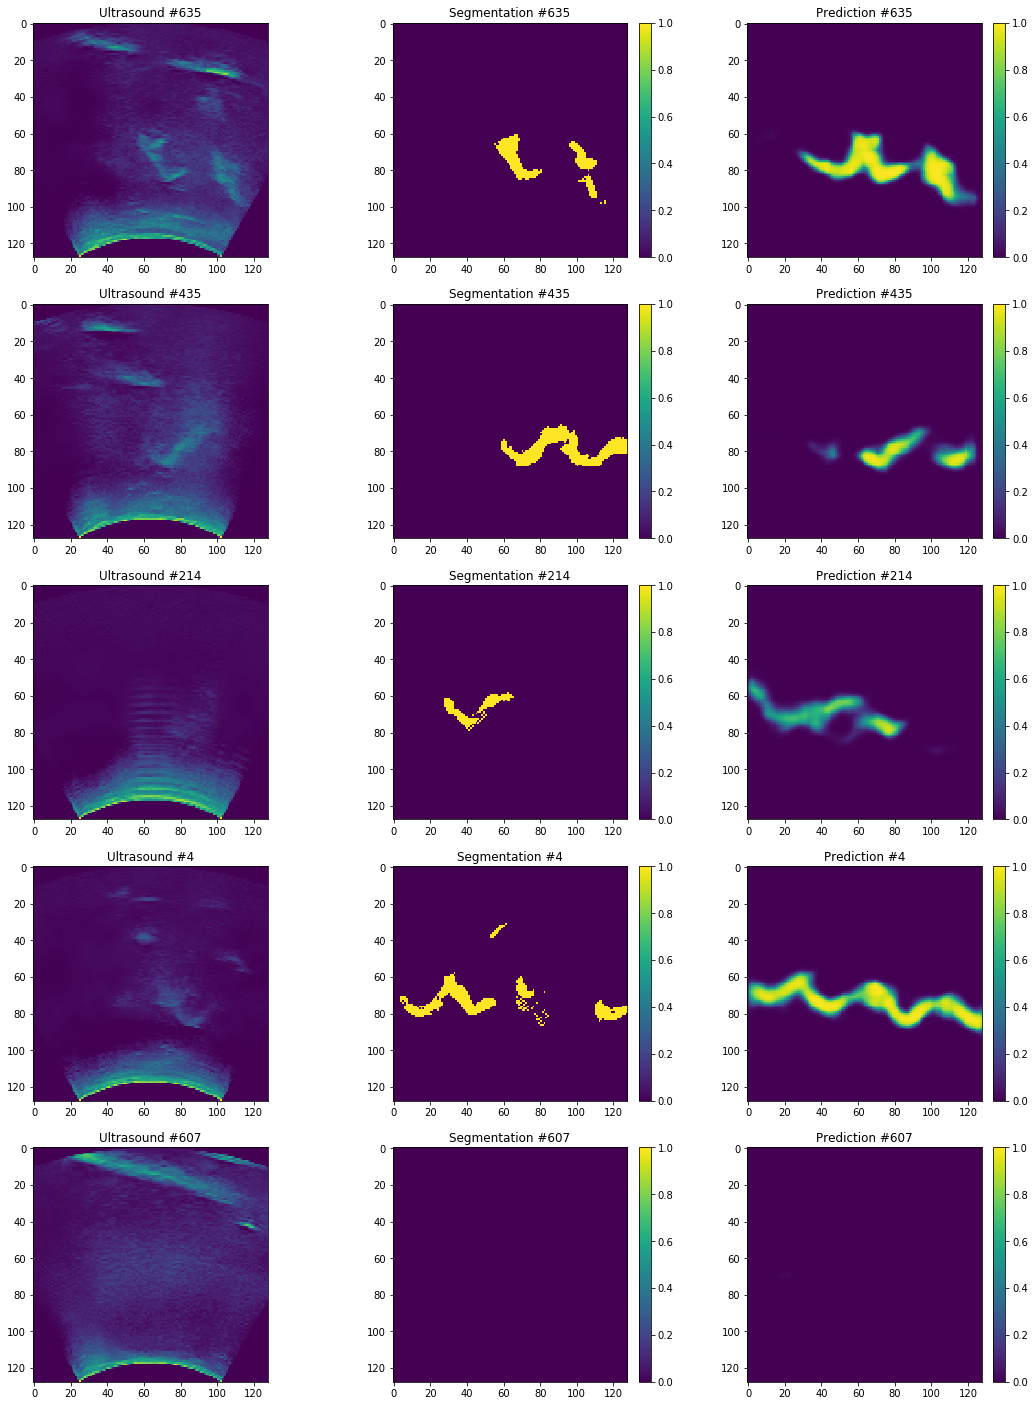

In [16]:
from random import sample

num_test = test_ultrasound_data.shape[0]
num_show = 5

indices = [i for i in range(num_test)]
sample_indices = sample(indices, num_show)

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show,3,i*3+1)
    img0 = a0.imshow(test_ultrasound_data[sample_indices[i], :, :, 0].astype(np.float32))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show,3,i*3+2)
    img1 = a1.imshow(test_segmentation_data[sample_indices[i], :, :, 0], vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show,3,i*3+3)
    img2 = a2.imshow(y_pred[sample_indices[i], :, :, 1], vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)

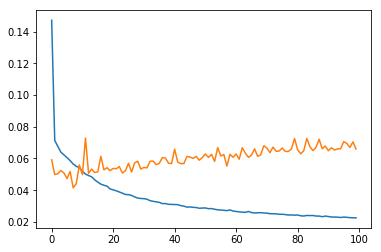

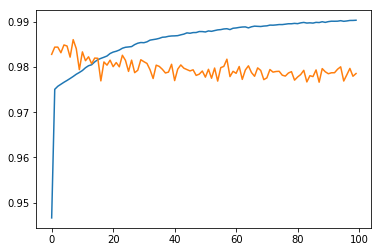

In [14]:
plt.plot(training_log.history['loss'])
plt.plot(training_log.history['val_loss'])
plt.show()
plt.plot(training_log.history['acc'])
plt.plot(training_log.history['val_acc'])
plt.show()

In [15]:
#Write the predicted ouput to a numpy array
np.save('predictions.npy', y_pred)

In [22]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = os.path.join(root_folder, "saved_models")

if not os.path.exists(saved_models_folder):
    os.makedirs(saved_models_folder)
    print("Creating folder: {}".format(saved_models_folder))

model_file_name = "model_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model.save(weights_file_path)

print("Model saved to: {}".format(weights_file_path))

Model saved to: C:\Users\victoria\05-21-2019 SpineExport\saved_models\model_2019-06-18_10-31-55.h5
